In [1]:
import os
import json
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
def load_json_res(pcc, data_dir):
    with open(f"{data_dir}/{pcc}_FEN.JSON") as f:
        rep = json.load(f)
    F_fen = rep["FE"]
    F_fen_err = rep["FE_error"]

    with open(f"{data_dir}/{pcc}_DEC.JSON") as f:
        rep = json.load(f)
    F_dec = rep["FE"]
    F_dec_err = rep["FE_error"]
    return {"PCC": [rep["PCC"]], "F_FEN": [float(F_fen)], "err_FEN": [float(F_fen_err)],
             "F_DEC": [float(F_dec)], "err_DEC": [float(F_dec_err)]}

def load_data(data_dir):
    PCC_list = []
    for folder in os.listdir(data_dir):
        if re.match("[A-Z]{5}_[A-Z]{3}", folder):
            PCC_list.append(folder.split("_")[0])

    PCC_list = set(PCC_list)
    data = []
    for pcc in PCC_list:
        try:
            data.append(pd.DataFrame(load_json_res(pcc, data_dir)))
        except:
            print(f"Skipping {pcc}.")

    data = pd.concat(data)
    data.reset_index(inplace=True, drop=True)
    return data

In [3]:
dataset = load_data("../MD_results")
AAindex1 = pd.read_csv("./AAindex1.csv", index_col=0)

In [4]:
lasso_data = {"PCC": []}
for pp in AAindex1.property:
    lasso_data[pp] = []

In [5]:
for pcc in dataset.PCC:
    lasso_data["PCC"].append(pcc)
    for pp in AAindex1.property:
        pps = []
        for aa in pcc:
            pps.append(AAindex1[AAindex1.property == pp][aa].values[0])
        nancnt = np.count_nonzero(np.isnan(pps))
        if nancnt == 5:
            lasso_data[pp].append(0.0)
        else:
            lasso_data[pp].append(np.nanmean(pps))

In [6]:
lasso_data = pd.DataFrame(lasso_data)
lasso_data.head(10)

,PCC,alpha-CH chemical shifts,Hydrophobicity index,Signal sequence helical potential,Membrane-buried preference parameters,Conformational parameter of inner helix,Conformational parameter of beta-structure,Conformational parameter of beta-turn,Average flexibility indices,Residue volume,...,Weighted domination number using the atomic number,Average weighted eccentricity based on the the atomic number,Weighted radius based on the atomic number,Weighted diameter based on the atomic number,Total weighted atomic number of the graph,Average weighted atomic number or degree based on atomic number in the graph,Weighted maximum eigenvalue based on the atomic numbers,Weighted minimum eigenvalue based on the atomic numbers,Weighted average eigenvalue based on the atomic numbers,Weighted second smallest eigenvalue of the weighted Laplacian matrix
0,PRWET,4.432,1.144,0.536,0.686,0.496,0.684,0.812,0.4568,94.80,...,14.6,20.8688,14.4,25.2,40.8,5.7474,25.9342,-0.8032,11.0168,5.2132
1,WWWWL,4.594,2.426,1.262,1.450,0.784,0.782,0.882,0.3170,128.72,...,21.6,25.1200,16.8,32.4,60.4,5.7336,28.8266,0.1688,12.1200,2.2578
2,YYHHT,4.562,1.006,0.448,0.570,0.504,0.830,0.786,0.3860,97.48,...,14.4,22.8320,16.8,30.4,46.6,5.4480,25.7618,-1.9230,10.8488,2.4816
3,YGLHT,4.344,0.828,1.052,1.086,0.566,0.794,0.768,0.4192,83.52,...,10.4,16.4760,11.8,21.4,33.4,5.1640,21.6670,-1.3842,8.9444,2.4634
4,GGADG,4.204,0.256,0.540,0.712,0.498,0.674,0.850,0.5000,45.98,...,4.2,6.5800,4.2,8.8,13.4,4.6600,12.3268,0.0000,5.3800,0.5938
5,HWWWW,4.686,2.242,0.678,0.922,0.704,0.782,0.926,0.3086,126.70,...,22.2,26.6200,18.0,35.0,63.8,5.4736,28.6710,-0.1780,12.2800,1.9562
6,HGWYW,4.520,1.572,0.546,0.750,0.570,0.770,0.900,0.3794,103.04,...,16.4,21.8760,15.0,29.4,49.2,5.1508,23.8102,-0.4544,10.3244,1.4584
7,FGAAG,4.260,0.676,1.060,1.278,0.660,0.764,0.642,0.4232,58.34,...,6.4,8.4500,6.4,9.6,17.2,5.0000,12.9986,0.0000,6.2000,0.4052
8,GGTGP,4.140,0.442,0.614,0.706,0.310,0.666,0.926,0.5170,50.74,...,4.2,6.9800,4.6,8.8,14.4,4.3800,13.7638,-0.8454,6.3000,3.6000
9,GGAGY,4.172,0.540,0.608,0.820,0.498,0.710,0.824,0.4818,55.54,...,5.4,8.8560,5.8,12.4,17.8,4.5440,12.2504,-0.1920,5.7444,0.3198


In [7]:
std_df = lasso_data.drop(columns=["PCC"]).std()
low_std_cols = std_df[std_df.values < 0.01].index.values

In [8]:
lasso_data = lasso_data.loc[:, [i for i in lasso_data.columns if i not in low_std_cols]]

In [9]:
lasso_data

,PCC,alpha-CH chemical shifts,Hydrophobicity index,Signal sequence helical potential,Membrane-buried preference parameters,Conformational parameter of inner helix,Conformational parameter of beta-structure,Conformational parameter of beta-turn,Average flexibility indices,Residue volume,...,Weighted domination number using the atomic number,Average weighted eccentricity based on the the atomic number,Weighted radius based on the atomic number,Weighted diameter based on the atomic number,Total weighted atomic number of the graph,Average weighted atomic number or degree based on atomic number in the graph,Weighted maximum eigenvalue based on the atomic numbers,Weighted minimum eigenvalue based on the atomic numbers,Weighted average eigenvalue based on the atomic numbers,Weighted second smallest eigenvalue of the weighted Laplacian matrix
0,PRWET,4.432,1.144,0.536,0.686,0.496,0.684,0.812,0.4568,94.80,...,14.6,20.8688,14.4,25.2,40.8,5.7474,25.9342,-0.8032,11.0168,5.2132
1,WWWWL,4.594,2.426,1.262,1.450,0.784,0.782,0.882,0.3170,128.72,...,21.6,25.1200,16.8,32.4,60.4,5.7336,28.8266,0.1688,12.1200,2.2578
2,YYHHT,4.562,1.006,0.448,0.570,0.504,0.830,0.786,0.3860,97.48,...,14.4,22.8320,16.8,30.4,46.6,5.4480,25.7618,-1.9230,10.8488,2.4816
3,YGLHT,4.344,0.828,1.052,1.086,0.566,0.794,0.768,0.4192,83.52,...,10.4,16.4760,11.8,21.4,33.4,5.1640,21.6670,-1.3842,8.9444,2.4634
4,GGADG,4.204,0.256,0.540,0.712,0.498,0.674,0.850,0.5000,45.98,...,4.2,6.5800,4.2,8.8,13.4,4.6600,12.3268,0.0000,5.3800,0.5938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,AAAAA,4.350,0.610,1.180,1.560,1.000,0.770,0.370,0.3570,52.60,...,6.0,6.0000,6.0,6.0,12.0,6.0000,12.0000,0.0000,6.0000,0.0000
146,YGFWW,4.526,1.854,0.876,1.098,0.570,0.800,0.856,0.3776,107.44,...,17.0,21.9060,15.0,28.0,49.4,5.4108,24.3602,-0.1076,10.6444,1.5426
147,HWWWF,4.678,2.116,0.916,1.112,0.678,0.824,0.838,0.3104,122.40,...,21.0,25.7700,18.0,32.6,59.8,5.5402,28.1140,-0.2202,12.1300,1.9526
148,GGAGE,4.110,0.258,0.552,0.730,0.556,0.654,0.762,0.4972,49.24,...,4.2,7.5000,4.6,10.0,14.6,4.6340,12.3462,0.0000,5.4334,0.3644


In [10]:
corr_mat = lasso_data.drop(columns=["PCC"]).corr(method="spearman")

Low variance features (\<0.05) dropped

In [11]:
len(lasso_data.columns)-1

515

In [12]:
lasso_data_raw = lasso_data.copy()
# Calculate the correlation matrix
corr_mat = lasso_data.drop(columns=["PCC"]).corr(method="spearman")
threshold = 0.70  # Correlation threshold

to_keep = []
to_remove = []
bags = {}

while (len(to_keep) + len(to_remove))!= (len(lasso_data.columns)-1):
    curr_to_remove = []
    curr_col = corr_mat.columns[0]
    curr_vals = corr_mat[curr_col][1:]
    for i, val in enumerate(curr_vals):
        if abs(val) >= threshold:
            curr_to_remove.append(corr_mat.columns[i+1])
    to_keep.append(curr_col)
    to_remove.extend(curr_to_remove)
    bags[curr_col] = curr_to_remove
    corr_mat = lasso_data.drop(columns=["PCC"]+to_keep+to_remove).corr(method="spearman")

lasso_data = lasso_data[["PCC"] + to_keep]

In [13]:
bags_text = []
for key, values in bags.items():
    bags_text.append(f"* {key}:\n")
    if len(values) != 0:
        for val in values:
            bags_text.append(f"\t{val}\n")
    else:
        bags_text.append(f"\t\n")

with open("desc_bags.txt", "w") as f:
    f.writelines(bags_text)

In [14]:
lasso_data

,PCC,alpha-CH chemical shifts,Signal sequence helical potential,Conformational parameter of inner helix,Conformational parameter of beta-structure,Conformational parameter of beta-turn,Retention coefficient in TFA,alpha-NH chemical shifts,Normalized frequency of extended structure,A parameter defined from the residuals obtained from the best correlation of,...,Principal property value z3,"Normalized positional residue frequency at helix termini N""",Normalized positional residue frequency at helix termini N5,Normalized positional residue frequency at helix termini Cc,"Normalized positional residue frequency at helix termini C""",Normalized positional residue frequency at helix termini C4',Side-chain conformation by gaussian evolutionary method,"Hydrophobicity coefficient in RP-HPLC, C18 with 0.1%TFA/2-PrOH/MeCN/H2O",Linker propensity from 1-linker dataset,Linker propensity from small dataset
0,PRWET,4.432,0.536,0.496,0.684,0.812,2.30,6.5944,0.3166,0.0406,...,-0.366,1.012,0.998,0.844,0.988,1.0632,0.7760,1.306,1.0894,0.9894
1,WWWWL,4.594,1.262,0.784,0.782,0.882,17.04,8.1598,0.2648,0.1160,...,0.484,1.040,0.838,0.736,1.080,1.1680,0.8660,3.090,0.9252,1.0520
2,YYHHT,4.562,0.448,0.504,0.830,0.786,1.68,8.2864,0.3292,0.1260,...,0.168,1.154,0.688,1.208,1.188,0.8092,0.8860,-2.194,0.9450,0.8880
3,YGLHT,4.344,1.052,0.566,0.794,0.768,4.68,8.3296,0.3458,0.0900,...,-0.192,1.124,0.772,1.106,1.126,0.7952,0.8675,-1.072,0.9658,0.9690
4,GGADG,4.204,0.540,0.498,0.674,0.850,0.16,8.3664,0.2990,0.0484,...,0.670,1.244,0.732,0.826,1.064,1.0700,0.6600,-1.200,0.8802,0.9934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,AAAAA,4.350,1.180,1.000,0.770,0.370,7.30,8.2490,0.2880,-0.1180,...,0.090,1.050,1.800,1.190,0.930,0.7100,0.0000,-2.340,0.9740,1.0650
146,YGFWW,4.526,0.876,0.570,0.800,0.856,11.30,8.1980,0.3042,0.1058,...,0.492,1.054,0.710,0.832,1.080,1.0740,0.8925,1.222,0.9254,1.0520
147,HWWWF,4.678,0.916,0.678,0.824,0.838,13.20,8.1850,0.2422,0.1254,...,0.822,1.112,0.692,0.898,1.126,1.1660,0.8840,2.068,0.9416,1.0784
148,GGAGE,4.110,0.552,0.556,0.654,0.762,-0.68,8.3580,0.2972,-0.0102,...,0.184,1.188,0.898,0.936,1.048,1.0220,0.7300,-0.844,0.9126,0.9734


In [15]:
X_fit = []
Y_fit_FEN = []
Y_fit_ACT = []

for pcc in dataset.PCC:
    X_fit.append(lasso_data[lasso_data.PCC == pcc].values[0][1:])
    Y_fit_ACT.append(dataset[dataset.PCC == pcc].F_DEC.values[0])
    Y_fit_FEN.append(dataset[dataset.PCC == pcc].F_FEN.values[0])

X_fit = np.asarray(X_fit)
Y_fit_FEN = np.asarray(Y_fit_FEN).reshape(-1, 1)
Y_fit_ACT = np.asarray(Y_fit_ACT).reshape(-1, 1)

# FEN

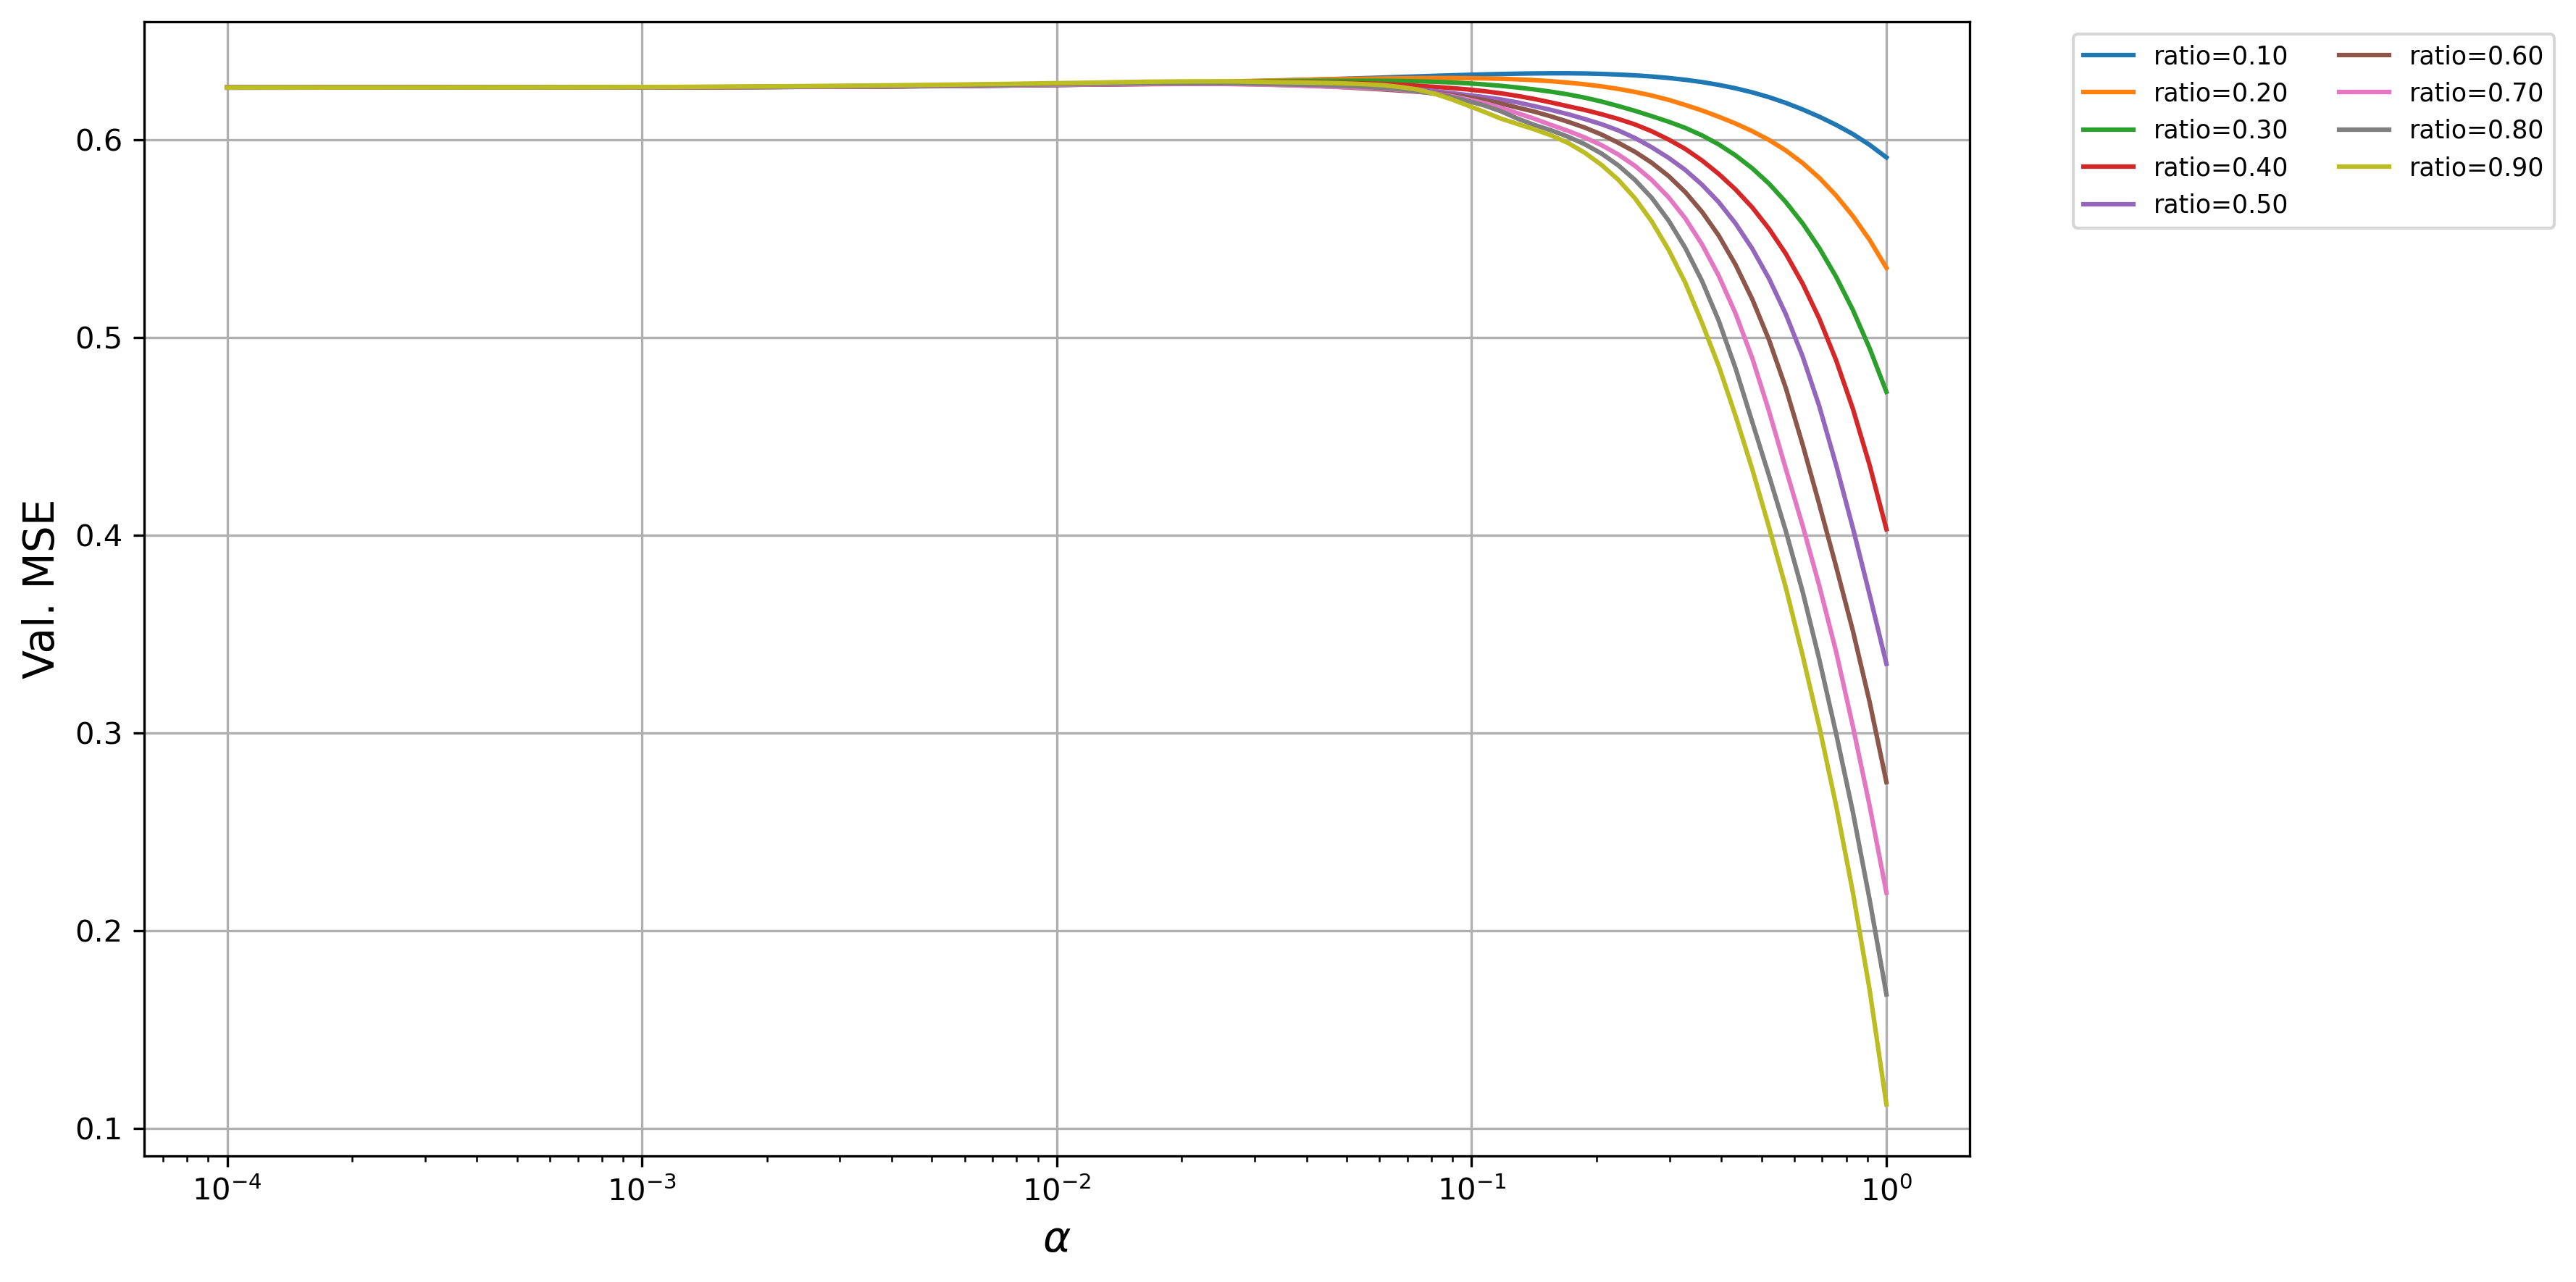

In [23]:
from sklearn.model_selection import KFold

# Define grid of lambda values (alphas in sklearn)
alphas = np.logspace(-4, 0, 100)
ratios = np.linspace(0.1, 0.9, 9)
n_features = X_fit.shape[1]
y = Y_fit_FEN

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store coefficients for each alpha and each fold
r2_scores = np.zeros((len(ratios), len(alphas), kf.get_n_splits()))
MSE = np.zeros((len(ratios), len(alphas), kf.get_n_splits()))

for i, (train_idx, val_idx) in enumerate(kf.split(X_fit)):
    X_train, y_train = X_fit[train_idx], y[train_idx]
    X_val, y_val = X_fit[val_idx], y[val_idx]
    #scaler_all_FEN = MinMaxScaler()
    scaler_all_FEN = StandardScaler()
    X_train = scaler_all_FEN.fit_transform(X_train)
    X_val = scaler_all_FEN.transform(X_val)
    for j, ratio in enumerate(ratios):
        for k, alpha in enumerate(alphas):
            model = ElasticNet(alpha=alpha, max_iter=100000, l1_ratio=ratio)
            model.fit(X_train, y_train)
            r2_scores[j, k, i] = model.score(X_val, y_val)
            MSE[j, k, i] = ((model.predict(X_val)-y_val)**2).mean()

# Create a figure and axis using the object-oriented API
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
colors = plt.cm.tab10.colors

# Plot regularization paths with error bars
#ax2 = ax.twinx()
for k in range(len(ratios)):
    MSE_means = MSE[k, :].mean(axis=1)
    #ax.plot(alphas, MSE_means, color=colors[k % len(colors)], label=f"ratio={ratios[k]:.2f}")
    r2_means = r2_scores[k, :].mean(axis=1)
    ax.plot(alphas, r2_means, color=colors[k % len(colors)], label=f"ratio={ratios[k]:.2f}")
ax.grid()
# Customize the plot
ax.set_xscale("log")
ax.set_xlabel(r"$\alpha$", fontsize=14)
ax.set_ylabel("Val. MSE", fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)
#ax.set_xlim(0.001, 1)
#ax.set_ylim(-4, 3)
ax.tick_params(axis="both", which='major', labelsize=10)
#ax2.set_ylim(1, 5)
fig.tight_layout()

# Display the plot
plt.show()

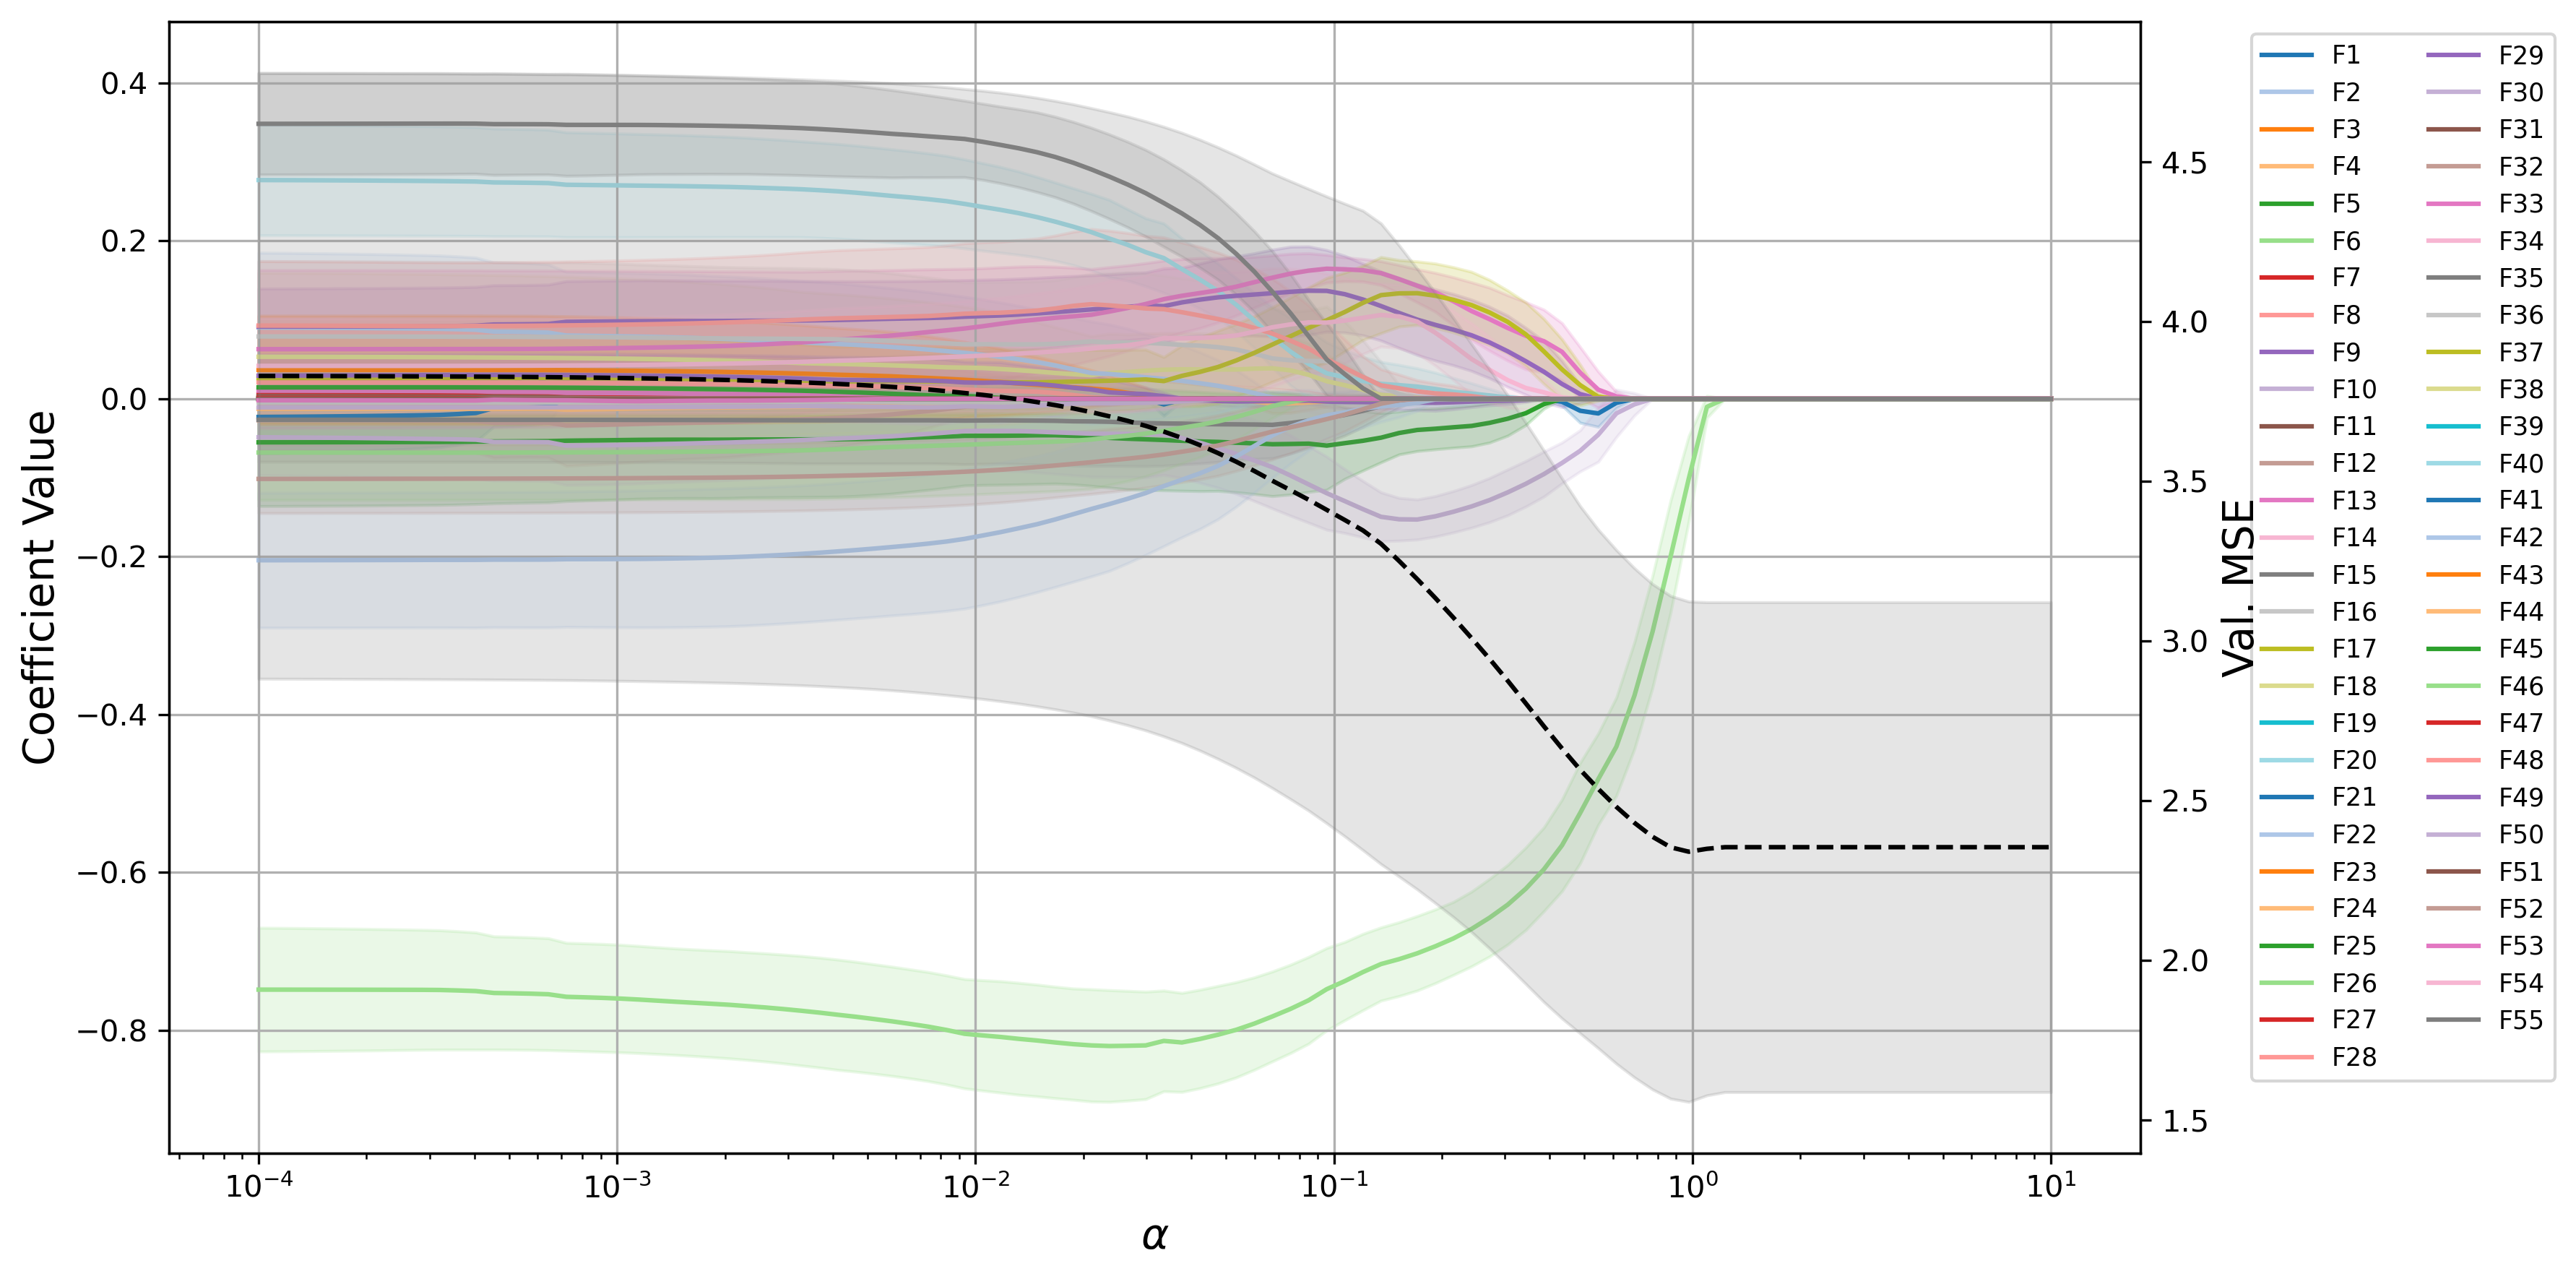

In [ ]:
# Define grid of lambda values (alphas in sklearn)
alphas = np.logspace(-4, 1, 100)
n_features = X_fit.shape[1]
y = Y_fit_FEN

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store coefficients for each alpha and each fold
coefficients = np.zeros((len(alphas), n_features, kf.get_n_splits()))
r2_scores = np.zeros((len(alphas), kf.get_n_splits()))
r2_scores_t = np.zeros((len(alphas), kf.get_n_splits()))
MSE = np.zeros((len(alphas), kf.get_n_splits()))
MSE_t = np.zeros((len(alphas), kf.get_n_splits()))

for i, (train_idx, val_idx) in enumerate(kf.split(X_fit)):
    X_train, y_train = X_fit[train_idx], y[train_idx]
    X_val, y_val = X_fit[val_idx], y[val_idx]
    #scaler_all_FEN = MinMaxScaler()
    scaler_all_FEN = StandardScaler()
    X_train = scaler_all_FEN.fit_transform(X_train)
    X_val = scaler_all_FEN.transform(X_val)
    for j, alpha in enumerate(alphas):
        model = ElasticNet(alpha=alpha, max_iter=100000, l1_ratio=0.5)
        model.fit(X_train, y_train)
        coefficients[j, :, i] = model.coef_
        r2_scores[j, i] = model.score(X_val, y_val)
        r2_scores_t[j, i] = model.score(X_train, y_train)
        MSE[j, i] = ((model.predict(X_val)-y_val)**2).mean()
        MSE_t[j, i] = ((model.predict(X_train)-y_train)**2).mean()

# Compute mean and standard deviation of coefficients across folds
mean_coefficients = coefficients.mean(axis=2)
std_coefficients = coefficients.std(axis=2)

# Create a figure and axis using the object-oriented API
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
colors = plt.cm.tab20.colors

# Plot regularization paths with error bars
for k in range(n_features):
    ax.plot(alphas, mean_coefficients[:, k], color=colors[k % len(colors)], label=f"F{k+1}")
    ax.fill_between(
        alphas,
        mean_coefficients[:, k] - std_coefficients[:, k],
        mean_coefficients[:, k] + std_coefficients[:, k],
        alpha=0.2,
        color=colors[k % len(colors)]
    )
ax2 = ax.twinx()
r2_means = r2_scores.mean(axis=1)
r2_stds = r2_scores.std(axis=1)
MSE_means = MSE.mean(axis=1)
MSE_stds = MSE.std(axis=1)
# ax2.plot(alphas, r2_means, "--k")
# ax2.fill_between(
#         alphas,
#         r2_means - r2_stds,
#         r2_means + r2_stds,
#         alpha=0.2,
#         color='grey'
#     )
ax2.plot(alphas, MSE_means, "--k")
ax2.fill_between(
        alphas,
        MSE_means - MSE_stds,
        MSE_means + MSE_stds,
        alpha=0.2,
        color='grey'
    )
ax.grid()
# Customize the plot
ax.set_xscale("log")
ax.set_xlabel(r"$\alpha$", fontsize=14)
ax.set_ylabel("Coefficient Value", fontsize=14)
#ax.set_title("Regularization Path (Averaged Over Folds)", fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)
#ax.set_xlim(0.001, 1)
#ax.set_ylim(-4, 3)
ax.tick_params(axis="both", which='major', labelsize=10)
ax2.tick_params(axis="both", which='major', labelsize=10)
ax2.set_ylabel("Val. MSE", fontsize=14)
#ax2.set_ylim(1, 5)
fig.tight_layout()

# Display the plot
plt.show()

